## Environment setup

### Packages

In [15]:
import os

import torch
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.transforms import functional as F
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

import matplotlib.pyplot as plt
%matplotlib inline 

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from nuscenes.utils.geometry_utils import box_in_image, BoxVisibility

import numpy as np

from pyquaternion import Quaternion

### Functions

In [6]:
def get_sample_data(nusc_object, sample_data_token, box_vis_level=BoxVisibility.ANY, selected_anntokens=None):
    """
    Returns the data path as well as all annotations related to that sample_data(single image).
    Note that the boxes are transformed into the current sensor's coordinate frame.
    :param sample_data_token: <str>. Sample_data token(image token).
    :param box_vis_level: <BoxVisibility>. If sample_data is an image, this sets required visibility for boxes.
    :param selected_anntokens: [<str>]. If provided only return the selected annotation.
    :return: (data_path <str>, boxes [<Box>], camera_intrinsic <np.array: 3, 3>)
    """

    # Retrieve sensor & pose records
    sd_record = nusc_object.get('sample_data', sample_data_token)
    cs_record = nusc_object.get('calibrated_sensor', sd_record['calibrated_sensor_token'])
    sensor_record = nusc_object.get('sensor', cs_record['sensor_token'])
    pose_record = nusc_object.get('ego_pose', sd_record['ego_pose_token'])

    sample_record = nusc_object.get('sample',sd_record['sample_token'])
    data_path = nusc_object.get_sample_data_path(sample_data_token)

    if sensor_record['modality'] == 'camera':
        cam_intrinsic = np.array(cs_record['camera_intrinsic'])
        imsize = (sd_record['width'], sd_record['height'])
    else:
        cam_intrinsic = None
        imsize = None

    # Retrieve all sample annotations and map to sensor coordinate system.
    if selected_anntokens is not None:
        boxes = list(map(nusc_object.get_box, selected_anntokens))
    else:
        boxes = nusc_object.get_boxes(sample_data_token)
        selected_anntokens = sample_record['anns']

    # Make list of Box objects including coord system transforms.
    box_list = []
    ann_list = []
    for box,ann in zip(boxes,selected_anntokens):

        # Move box to ego vehicle coord system
        box.translate(-np.array(pose_record['translation']))
        box.rotate(Quaternion(pose_record['rotation']).inverse)

        #  Move box to sensor coord system
        box.translate(-np.array(cs_record['translation']))
        box.rotate(Quaternion(cs_record['rotation']).inverse)

        if sensor_record['modality'] == 'camera' and not \
                box_in_image(box, cam_intrinsic, imsize, vis_level=box_vis_level):
            continue

        box_list.append(box)
        ann_list.append(ann)
    #this is for a single sample image
    return data_path, box_list, ann_list, cam_intrinsic #single image info

def threeD_2_twoD(boxsy, intrinsic): #input is a single annotation box
    '''
    given annotation boxes and intrinsic camera matrix
    outputs the 2d bounding box coordinates as a list (all annotations for a particular sample image)
    '''
    corners = boxsy.corners()
    x = corners[0,:]
    y = corners[1,:]
    z = corners[2,:]
    x_y_z = np.array((x,y,z))
    orthographic = np.dot(intrinsic,x_y_z)
    perspective_x = orthographic[0]/orthographic[2]
    perspective_y = orthographic[1]/orthographic[2]
    
    min_x = np.min(perspective_x)
    max_x = np.max(perspective_x)
    min_y = np.min(perspective_y)
    max_y = np.max(perspective_y)
    
    return min_x, min_y, max_x, max_y

### Global variables

In [7]:
nusc = NuScenes(version='v1.0-trainval', dataroot='/storage/tiago/conecta2030/nuScenes-exploration/data', verbose=True)

Loading NuScenes tables for version v1.0-trainval...
23 category,
8 attribute,
4 visibility,
64386 instance,
12 sensor,
10200 calibrated_sensor,
2631083 ego_pose,
68 log,
850 scene,
34149 sample,
2631083 sample_data,
1166187 sample_annotation,
4 map,
Done loading in 37.608 seconds.
Reverse indexing ...
Done reverse indexing in 9.8 seconds.


In [8]:
model = ssd300_vgg16(weights=SSD300_VGG16_Weights.DEFAULT)
print(model)

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [9]:
DETECTION_THRESHOLD = 0.8
IMAGE_PREPROCESSING_FUNCTION = SSD300_VGG16_Weights.DEFAULT.transforms()

## Main program

Retrieving camera data for an example image of the nuScenes test dataset.

In [10]:
my_scene = nusc.scene[70]
first_sample_token = my_scene['first_sample_token']
my_sample = nusc.get('sample', first_sample_token)
cam_front_data = nusc.get('sample_data', my_sample['data']['CAM_FRONT'])

Rendering the image using a nuScenes function:

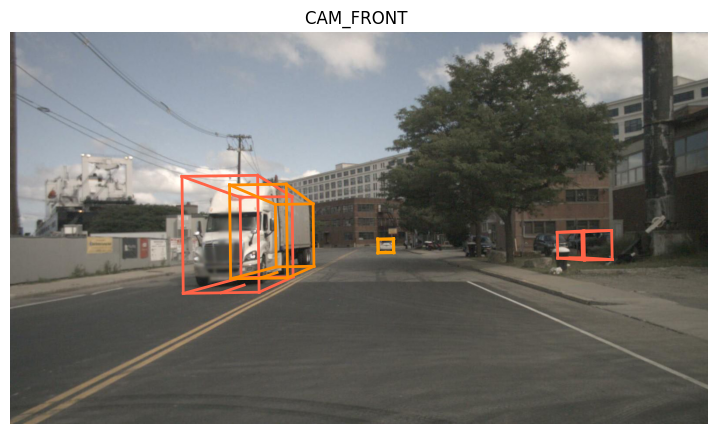

In [11]:
nusc.render_sample_data(cam_front_data['token'])

Using auxiliar functions to convert the 3D bounding boxes from nuScenes into 2D bounding boxes:

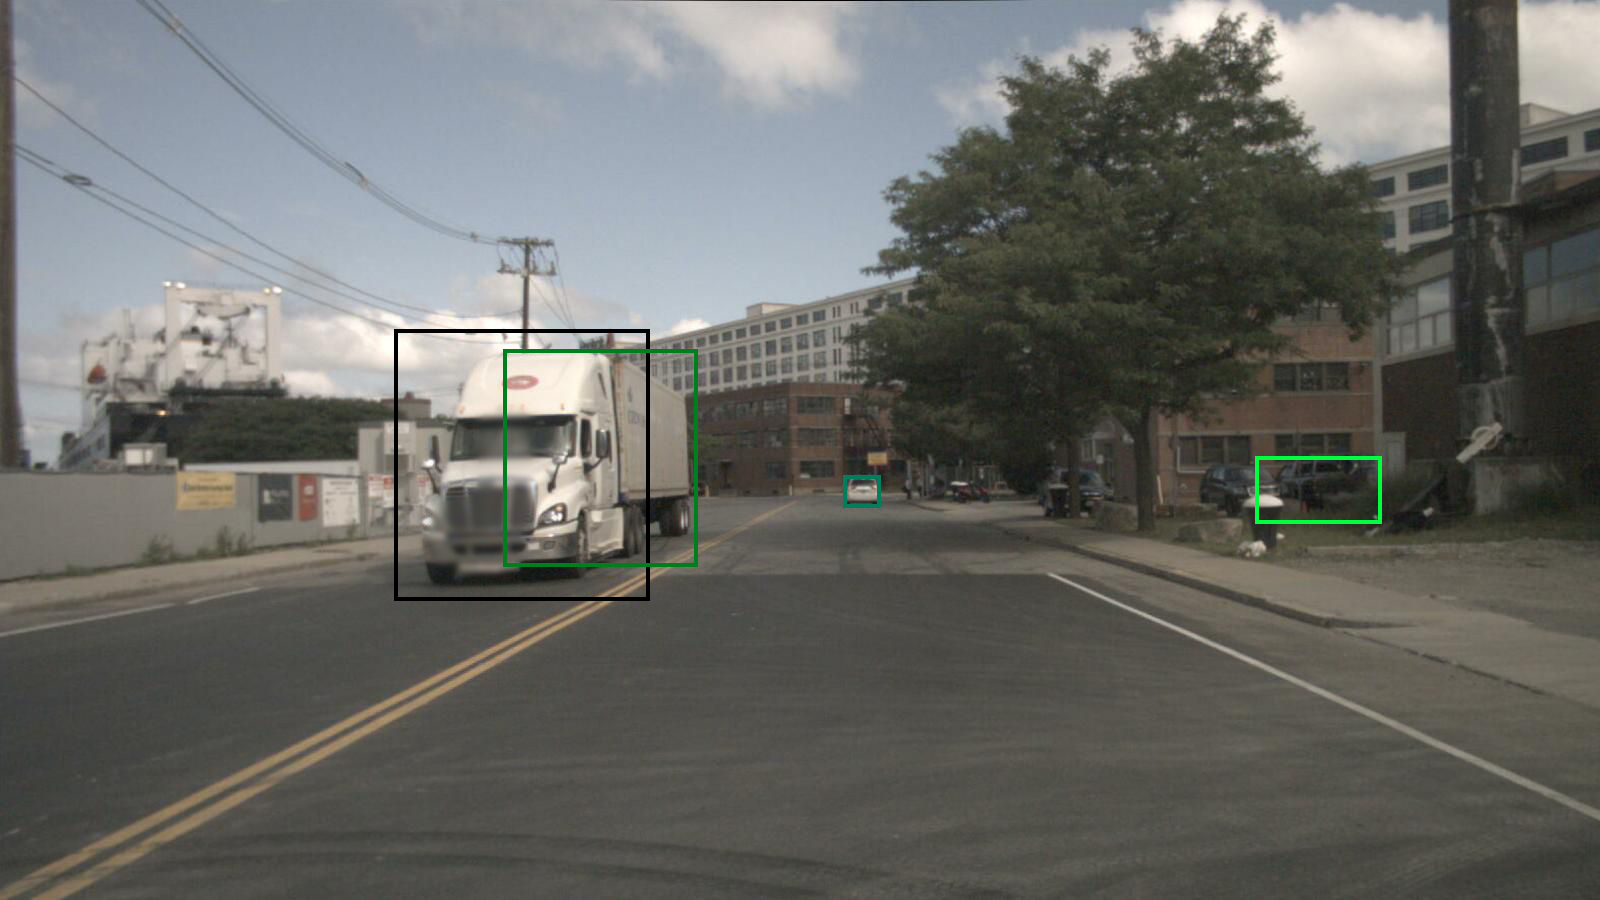

In [17]:
path, boxes, anns, intrinsic_matrix = get_sample_data(nusc, cam_front_data['token'])
boxes_2d = torch.tensor([threeD_2_twoD(box, intrinsic_matrix) for box in boxes])

F.to_pil_image(draw_bounding_boxes(
    read_image(os.path.join(nusc.dataroot, cam_front_data['filename'])),
    boxes=boxes_2d,
    width=4
))

Rendering the same image (without bounding boxes) with PyTorch utilities funtions:

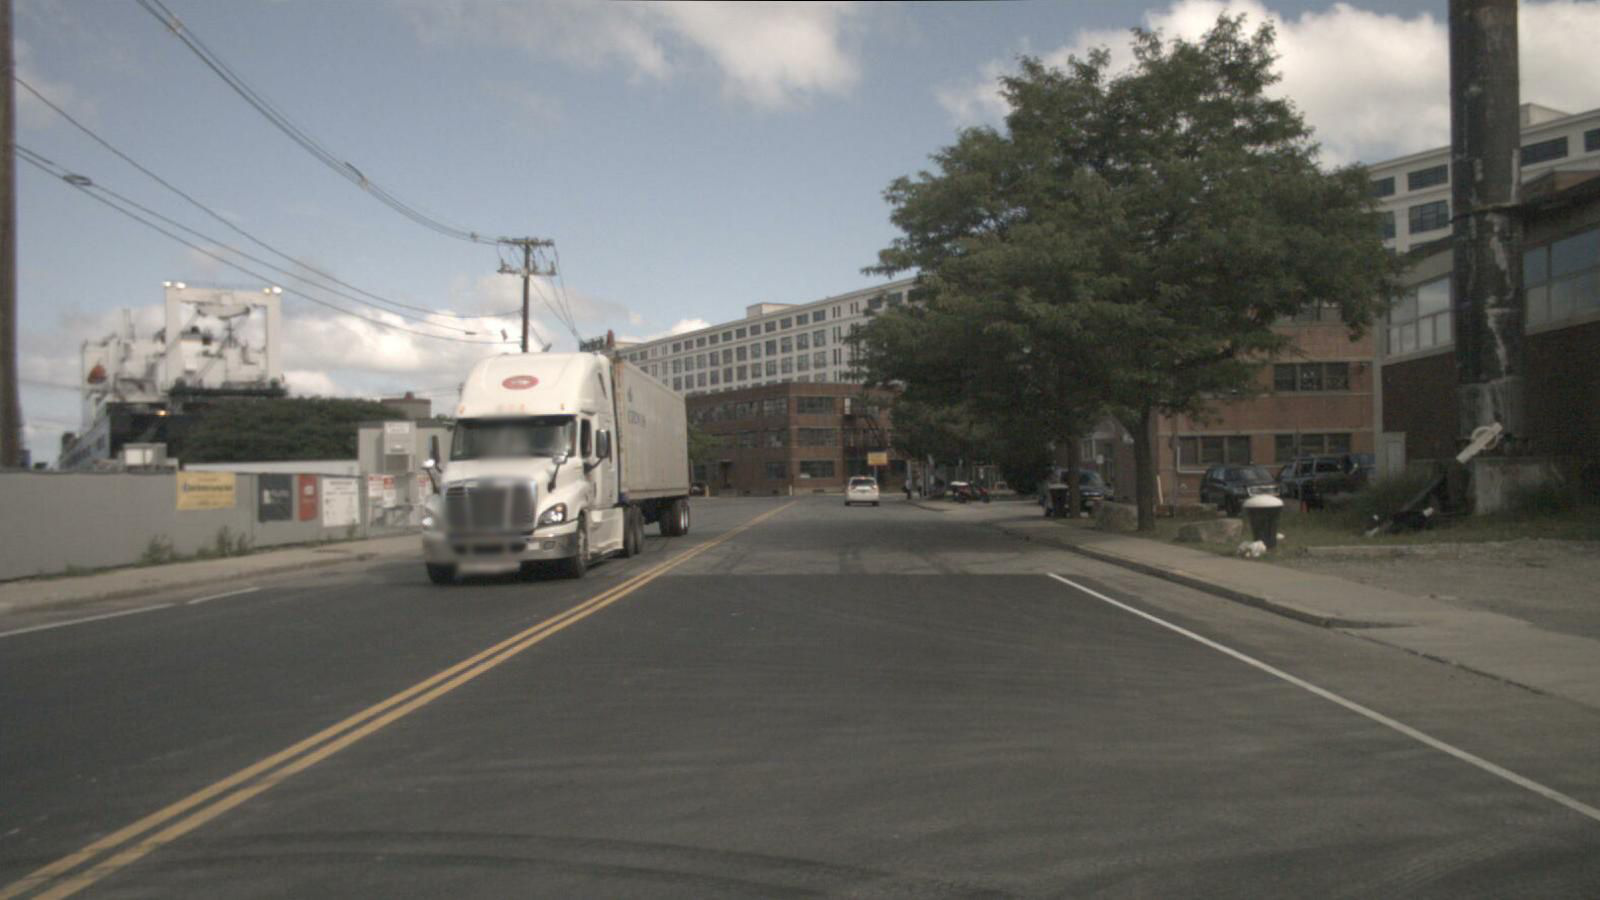

In [135]:
F.to_pil_image(read_image(os.path.join(nusc.dataroot, cam_front_data['filename'])))

Prediction

In [137]:
model.eval()

# list of predictions (per image):
out = model([IMAGE_PREPROCESSING_FUNCTION(read_image(os.path.join(nusc.dataroot, cam_front_data['filename'])))])

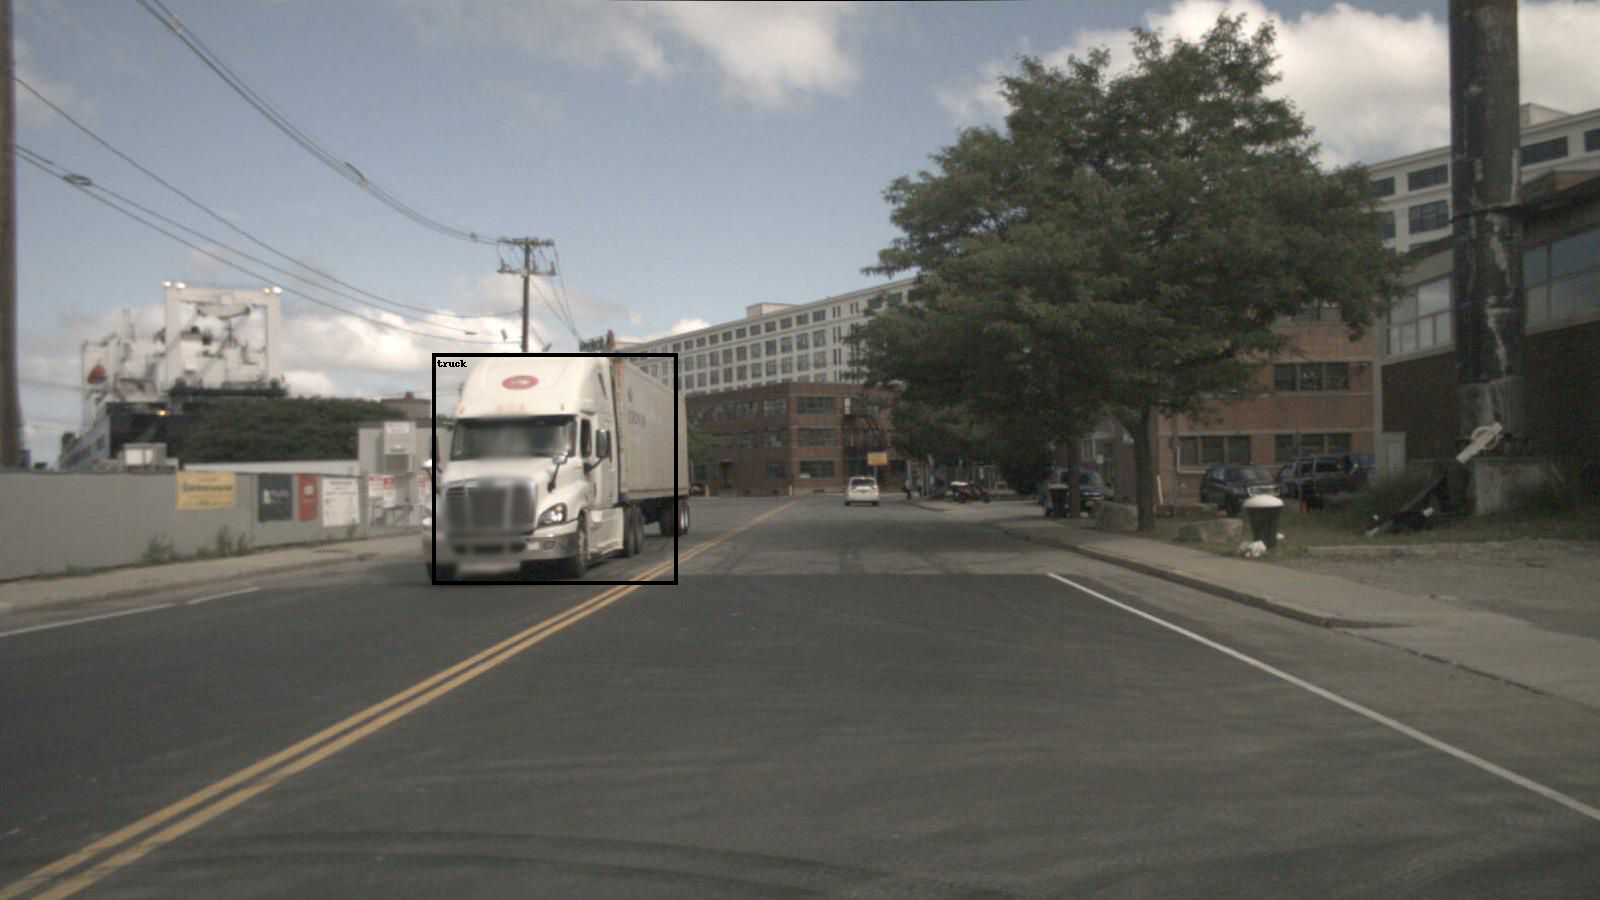

In [141]:
# filter the bounding boxes in order to select only the ones with a score higher than the DETECTION_THRESHOLD:
above_threshold_indices = out[0]['scores'] > DETECTION_THRESHOLD
filtered_boxes = out[0]['boxes'][above_threshold_indices]

# also filter the predicted labels, by selecting only the ones at the same indexes of the filtered bounding boxes:
filtered_labels = [SSD300_VGG16_Weights.DEFAULT.meta["categories"][label] for label in out[0]['labels'][above_threshold_indices]]

# render image with predicted and filtered boundig boxes and labels:
F.to_pil_image(draw_bounding_boxes(
    read_image(os.path.join(nusc.dataroot, cam_front_data['filename'])),
    boxes=filtered_boxes,
    labels=filtered_labels,
    width=4,
))